<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_02_automated_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML

In [2]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import math 
import matplotlib

from scipy import stats
from collections import Counter
from pathlib import Path

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

# Automated feature engineering
import featuretools as ft

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display

from utils import *
from preprocess import *

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [4]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [5]:
DATASET_PATH = Path("datasets/lotto")
DATASET = DATASET_PATH/"4D.zip"

In [6]:
data = format_tabular(DATASET)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106398 entries, 0 to 106397
Data columns (total 4 columns):
DrawNo       106398 non-null int64
DrawDate     106398 non-null datetime64[ns]
PrizeType    106398 non-null object
LuckyNo      106398 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.2+ MB


In [8]:
data.tail(10)

,DrawNo,DrawDate,PrizeType,LuckyNo
106388,503319,2019-11-17,SpecialNo1,2457
106389,503319,2019-11-17,SpecialNo10,4508
106390,503319,2019-11-17,SpecialNo2,2647
106391,503319,2019-11-17,SpecialNo3,2911
106392,503319,2019-11-17,SpecialNo4,7238
106393,503319,2019-11-17,SpecialNo5,4698
106394,503319,2019-11-17,SpecialNo6,1916
106395,503319,2019-11-17,SpecialNo7,1552
106396,503319,2019-11-17,SpecialNo8,3738
106397,503319,2019-11-17,SpecialNo9,6188


In [9]:
data.describe()

,DrawNo,LuckyNo
count,106398.000000,106398.000000
mean,272049.808690,4974.075838
std,133554.096792,2885.679139
min,40792.000000,0.000000
25%,156399.000000,2462.250000
50%,272056.000000,4952.000000
75%,387713.000000,7464.000000
max,503319.000000,9999.000000


       DrawNo   DrawDate        PrizeType  LuckyNo  TotalStrike
6007    66894 1994-01-05  ConsolationNo10     1760            1
12089   93295 1995-09-10      SpecialNo10     1760            1
33221  185101 2001-06-09   ConsolationNo6     1760            1
41325  220403 2003-08-10       SpecialNo4     1760            1
56402  286007 2007-06-24   ConsolationNo3     1760            1
67267  333210 2010-04-10       SpecialNo2     1760            1
70041  345310 2010-12-19   ConsolationNo3     1760            1
72759  357111 2011-08-21   ConsolationNo7     1760            1
75155  367512 2012-03-20      SpecialNo10     1760            1
88140  424015 2015-05-17  ConsolationNo10     1760            1
88193  424215 2015-05-23   ConsolationNo8     1760            1
94840  453117 2017-01-04   ConsolationNo8     1760            1


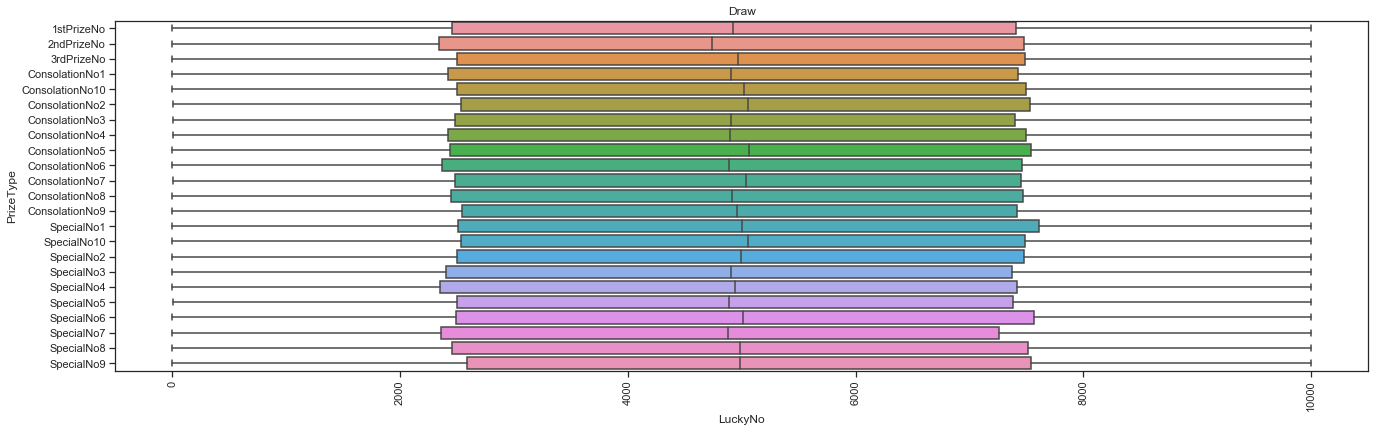

In [97]:
plt.figure(figsize=(20,6))
sns.boxplot(x='LuckyNo', y='PrizeType',data=data)
plt.xticks(rotation=90)
plt.title('Draw')

print(data[data['LuckyNo']==1760])

## Exploration

In [11]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

## Making Labels

In [13]:
data['TotalStrike'] = 1
data.head(10)

,DrawNo,DrawDate,PrizeType,LuckyNo,TotalStrike
0,40792,1992-05-06,1stPrizeNo,19,1
1,40792,1992-05-06,2ndPrizeNo,1124,1
2,40792,1992-05-06,3rdPrizeNo,592,1
3,40792,1992-05-06,ConsolationNo1,5311,1
4,40792,1992-05-06,ConsolationNo10,407,1
5,40792,1992-05-06,ConsolationNo2,1949,1
6,40792,1992-05-06,ConsolationNo3,1606,1
7,40792,1992-05-06,ConsolationNo4,3775,1
8,40792,1992-05-06,ConsolationNo5,6226,1
9,40792,1992-05-06,ConsolationNo6,1271,1


In [125]:
def make_cutoffs(start_date, end_date, threshold=0):
    # Find numbers exist before start date
    number_pool = data[data['DrawDate'] < start_date]['LuckyNo'].unique()
    tmp = pd.DataFrame({'LuckyNo': number_pool})
   
    # For numbers in the number pool, find their strike count between the start and end dates
    strike_counts = data[data['LuckyNo'].isin(number_pool) & 
        (data['DrawDate'] >= start_date) & 
        (data['DrawDate']< end_date)
    ].groupby('LuckyNo')['TotalStrike'].count().reset_index()
    
    number_of_draws = data[
                 (data['DrawDate'] >= start_date) & 
                 (data['DrawDate']< end_date)]['DrawDate'].nunique()
    # display(strike_counts)
    # print(number_of_draws)
    
    # Merge with all the number ids to record all customers who existed before start date
    strike_counts = strike_counts.merge(tmp, on='LuckyNo', how='right')
    
    # Set the total for any numbers who did not strike in the timeframe equal to 0
    strike_counts['TotalStrike'] = strike_counts['TotalStrike'].fillna(0)
    
    # Label is based on the threshold
    strike_counts['Label'] = (strike_counts['TotalStrike'] > threshold).astype(int)
        
    # The cutoff time is the start date
    strike_counts['cutoff_time'] = pd.to_datetime(start_date)
    strike_counts = strike_counts[['LuckyNo', 'cutoff_time', 'TotalStrike', 'Label']]
    
    #display(strike_counts[strike_counts['Label']==1].nunique())
    #display(strike_counts.sort_values(by='TotalStrike', ascending=False))
   
    return number_of_draws, strike_counts

In [128]:
number_of_draws, may_2015 = make_cutoffs(pd.datetime(2015, 5, 1), pd.datetime(2015, 6, 1))
#display(len(may_2015))
#display(may_2015[may_2015['Label']==1].nunique())
may_2015[may_2015['Label']==1 & (may_2015['TotalStrike']==2)].sort_values(by='TotalStrike', ascending=False).head()

,LuckyNo,cutoff_time,TotalStrike,Label
37,904,2015-05-01,2.0,1
114,3012,2015-05-01,2.0,1
333,9160,2015-05-01,2.0,1
340,9417,2015-05-01,2.0,1
344,9588,2015-05-01,2.0,1


Text(0.5, 1.0, 'Label Distribution for May')

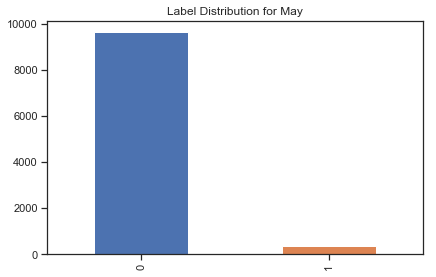

In [131]:
may_2015['Label'].value_counts().plot.bar()
plt.title('Label Distribution for May')

In [132]:
CUT_OFF_YEAR=pd.datetime(2014, 1, 1)

In [152]:
## Loop through each month starting from CUT_OFF_YEAR

from dateutil.relativedelta import relativedelta

# print(data['DrawDate'].max())
max_year_month = data['DrawDate'].max() - relativedelta(months=1) + relativedelta(day=31)
print(f"Max month year: {max_year_month}")

start_year_month = CUT_OFF_YEAR

months_data = []
total_draws = 0
while start_year_month < max_year_month:
    start_date = start_year_month 
    end_date = start_date + relativedelta(months=1)
    start_year_month = start_year_month + relativedelta(months=1)
    #print(f"Labels from {start_date} to {end_date}")
    draw_count, month_data = make_cutoffs(start_date, end_date)
    total_draws = total_draws + draw_count
    months_data.append(month_data)

print(f"Total draws: {total_draws}")
print(f"Total draws: {data[(data['DrawDate'] >= CUT_OFF_YEAR) & (data['DrawDate'] <= max_year_month)]['DrawDate'].nunique()}")
print(f"Total months:{len(months_data)}")
print(f"Total records count: {sum([len(l) for l in months_data])}")
print([len(l) for l in months_data])

Max month year: 2019-10-31 00:00:00
Total draws: 1032
Total draws: 1032
Total months:70
Total records count: 699972
[9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9999, 9999, 9999, 9999, 9999, 9999, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]


In [153]:
labels = pd.concat(months_data)
labels.to_csv(DATASET_PATH/'labels.csv')
labels.describe()

,LuckyNo,TotalStrike,Label
count,699972.000000,699972.000000,699972.000000
mean,4999.414912,0.033907,0.033343
std,2886.751031,0.184113,0.179530
min,0.000000,0.000000,0.000000
25%,2499.000000,0.000000,0.000000
50%,4999.000000,0.000000,0.000000
75%,7499.000000,0.000000,0.000000
max,9999.000000,3.000000,1.000000


In [155]:
# plot_labels = labels.copy()
# plot_labels['month'] = plot_labels['cutoff_time'].dt.month

# plt.figure(figsize = (12, 6))
# sns.boxplot(x = 'month', y = 'TotalStrike', 
#             data = plot_labels[(plot_labels['TotalStrike'] > 0)]);
# plt.title('Distribution by Month');

In [158]:
labels.loc[labels['LuckyNo'] == 9016].head(10)

,LuckyNo,cutoff_time,TotalStrike,Label
6385,9016,2014-01-01,0.0,0
6402,9016,2014-02-01,0.0,0
6384,9016,2014-03-01,0.0,0
6394,9016,2014-04-01,0.0,0
6372,9016,2014-05-01,0.0,0
6395,9016,2014-06-01,0.0,0
6363,9016,2014-07-01,0.0,0
6401,9016,2014-08-01,0.0,0
6386,9016,2014-09-01,0.0,0
307,9016,2014-10-01,1.0,1


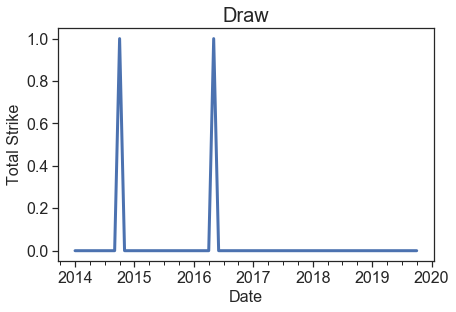

In [159]:
labels.loc[labels['LuckyNo'] == 9016].set_index('cutoff_time')['TotalStrike'].plot(figsize = (6, 4), linewidth = 3)
plt.xlabel('Date', size = 16); 
plt.ylabel('Total Strike', size = 16); 
plt.title('Draw', size = 20);
plt.xticks(size = 16); plt.yticks(size = 16);

## Automated Feature Engineering

In [12]:
es = ft.EntitySet(id="Results")

# Add the entire data table as an entity
es.entity_from_dataframe("results",
                         dataframe=df,
                         index="results_index",
                         time_index = 'DrawDate')

es['results']

2019-12-01 22:14:36,605 featuretools.entityset - WARNING    index results_index not found in dataframe, creating new integer column


Entity: results
  Variables:
    results_index (dtype: index)
    DrawNo (dtype: numeric)
    DrawDate (dtype: datetime_time_index)
    PrizeType (dtype: categorical)
    LuckyNo (dtype: numeric)
  Shape:
    (Rows: 106398, Columns: 5)

In [13]:
es['results'].df

,results_index,DrawNo,DrawDate,PrizeType,LuckyNo
0,0,40792,1992-05-06,1stPrizeNo,19
1,1,40792,1992-05-06,2ndPrizeNo,1124
2,2,40792,1992-05-06,3rdPrizeNo,592
3,3,40792,1992-05-06,ConsolationNo1,5311
4,4,40792,1992-05-06,ConsolationNo10,407
5,5,40792,1992-05-06,ConsolationNo2,1949
6,6,40792,1992-05-06,ConsolationNo3,1606
7,7,40792,1992-05-06,ConsolationNo4,3775
8,8,40792,1992-05-06,ConsolationNo5,6226
9,9,40792,1992-05-06,ConsolationNo6,1271
